# Prática 04 - Regressão

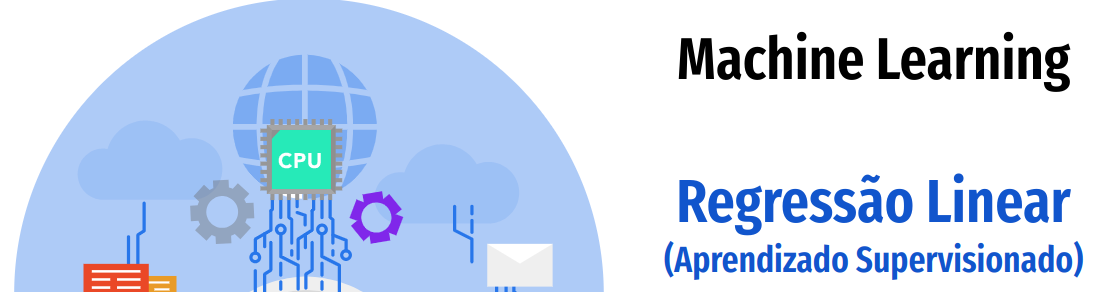

**Pessoa estudante**:  
- José Vitor Velozo de Carvalho (jvvc@cesar.school)
- Matheus Pereira do Rego Barros (mprb@cesar.school)

**Objetivo da Prática**


O objetivo desta prática é tentar predizer o valor da taxa pré-fixada relacionada ao título Tesouro IPCA 2024. O motivação desta previsão é tentar sempre tomar uma boa decisão de investimento.


**Instruções para a prática.**

1. Criar um dataset com informações macroeconômicas.

2. Realizar experimentos de regressão como indicado ao longo do notebook. Observe que o mesmo possui dicas espalhadas do que pode ser feito. Não necessariamente você precisa seguir 100% estas dicas.

3. **Submeter no Classroom até a data limite. Após o prazo limite, punição de -25 pontos por dia de atraso.**

4. Sugiro olhar o tópico de referências para usar as bibliotecas sugeridas para importar dados macroeconômicos.



In [443]:
# Obrigatoriamente vocês irão construir um dataset com informações entre estas duas datas.
# favor usar ao longo do código estas constantes!
START_DATE = '2014-01-02'
END_DATE = '2024-04-16'

DIRECTORY = "./datasets/ntn_b_principal"
anos = [2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024]

In [444]:
# Não apagar. recomendo usar essa lib para pegar os dados da SELIC e IPCA!
! pip install python-bcb
! pip install yfinance

In [445]:
# Imports!
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from bcb import currency
import yfinance as yf

## Parte 1 - Importação e Criação de dataset com dados macroeconômicos

Quais são os fatores que influenciam nas taxas dos títulos públicos? Claramente o dolar é um deles, mas note que é um fator externo. Lembre de incluir na sua análise os seguintes parâmetros:

- Taxa de Juros Brasileira (SELIC)
- Índice de inflação (IPCA) e/ou Expectativa do IPCA
- Valor do título do tesouro (NTN-B 2024).

O objetivo da prática é predizer o a coluna 'Taxa Compra Manhã'. Note que esta taxa está em porcentagem. Ao longo do código eu sugiro converter para número, fazendo a multiplicação por 100.

**Pontuação: 40 Pontos**

### Importação dos dados "NTN-B 2024"

NTN-B é o nome que se dá ao título do Tesouro Direto que é indexado à inflação. Justamente por ser indexado à inflação é que este título também é conhecido como Tesouro IPCA +. Na prática, NTN-B significa Nota do Tesouro Nacional série B. NTN-B e NTN-B Principal são apenas dois de vários títulos da dívida pública negociados no Tesouro Direto.

1. Acesse o site https://www.tesourodireto.com.br/titulos/historico-de-precos-e-taxas.htm

2. Baixe os arquivos históricos do título NTN-B 2024 de 2014 até 2024. Salve cada arquivo como (NTN-B_Principal_20xx.xls).

In [446]:
def create_ntnb_df() -> pd.DataFrame:
    dfs = []

    for filename in os.listdir(DIRECTORY):
        if filename.endswith(".xls"):
            file_path = os.path.join(DIRECTORY, filename)
            df = pd.read_excel(file_path, sheet_name="NTN-B Princ 150824", header=1)
            dfs.append(df)
    
    return pd.concat(dfs, ignore_index=True)

In [447]:
df = create_ntnb_df()

In [448]:
def adjust_ntnb_format(dfi: pd.DataFrame) -> pd.DataFrame:
  # Ajustar a taxa, está em %, vamos colocar em x.xx
  dfi['Taxa Compra Manhã'] = 100*dfi['Taxa Compra Manhã']
  dfi['Taxa Venda Manhã'] = 100*dfi['Taxa Venda Manhã']
  return dfi

In [449]:
df = adjust_ntnb_format(df)

In [450]:
def trim_df_by_date(dfi: pd.DataFrame) -> pd.DataFrame:
    dfi['Dia'] = pd.to_datetime(dfi['Dia'], dayfirst=True)
    dfi = dfi.loc[(dfi['Dia'] >= START_DATE) & (dfi['Dia'] <= END_DATE)]
    return dfi

In [451]:
df = trim_df_by_date(df)

In [452]:
# df.set_index('Dia', inplace=True)

In [453]:
df.head()

,Dia,Taxa Compra Manhã,Taxa Venda Manhã,PU Compra Manhã,PU Venda Manhã,PU Base Manhã
0,2014-01-02,6.43,6.51,1217.75,1208.11,1207.49
1,2014-01-03,6.47,6.55,1214.18,1204.58,1203.33
2,2014-01-06,6.47,6.55,1214.80,1205.20,1204.58
3,2014-01-07,6.48,6.56,1214.22,1204.63,1204.01
4,2014-01-08,6.46,6.54,1217.26,1207.64,1207.02


In [454]:
df.tail()

,Dia,Taxa Compra Manhã,Taxa Venda Manhã,PU Compra Manhã,PU Venda Manhã,PU Base Manhã
2558,2024-04-10,7.44,7.56,4148.19,4145.16,4145.16
2559,2024-04-11,7.53,7.65,4148.39,4145.36,4145.36
2560,2024-04-12,7.60,7.72,4149.30,4145.86,4145.86
2561,2024-04-15,7.48,7.60,4152.55,4149.30,4149.30
2562,2024-04-16,7.51,7.63,4153.84,4150.60,4150.60


In [455]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2563 entries, 0 to 2562
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Dia                2563 non-null   datetime64[ns]
 1   Taxa Compra Manhã  2563 non-null   float64       
 2   Taxa Venda Manhã   2563 non-null   float64       
 3   PU Compra Manhã    2563 non-null   float64       
 4   PU Venda Manhã     2563 non-null   float64       
 5   PU Base Manhã      2563 non-null   float64       
dtypes: datetime64[ns](1), float64(5)
memory usage: 140.2 KB


In [456]:
df.describe()

,Dia,Taxa Compra Manhã,Taxa Venda Manhã,PU Compra Manhã,PU Venda Manhã,PU Base Manhã
count,2563,2563.000000,2563.000000,2563.000000,2563.000000,2563.000000
mean,2019-02-19 14:29:10.136558592,5.158307,5.262645,2570.257448,2558.731420,2558.084175
min,2014-01-02 00:00:00,1.200000,1.320000,1161.240000,1152.160000,1151.130000
25%,2016-07-20 12:00:00,4.210000,4.330000,1819.595000,1811.355000,1810.435000
50%,2019-02-20 00:00:00,5.630000,5.740000,2542.270000,2526.430000,2525.060000
75%,2021-09-18 12:00:00,6.360000,6.440000,3237.225000,3225.365000,3223.930000
max,2024-04-16 00:00:00,7.970000,8.090000,4153.840000,4150.600000,4150.600000
std,NaN,1.651135,1.639582,854.780280,855.140675,855.367850


In [457]:
df

,Dia,Taxa Compra Manhã,Taxa Venda Manhã,PU Compra Manhã,PU Venda Manhã,PU Base Manhã
0,2014-01-02,6.43,6.51,1217.75,1208.11,1207.49
1,2014-01-03,6.47,6.55,1214.18,1204.58,1203.33
2,2014-01-06,6.47,6.55,1214.80,1205.20,1204.58
3,2014-01-07,6.48,6.56,1214.22,1204.63,1204.01
4,2014-01-08,6.46,6.54,1217.26,1207.64,1207.02
...,...,...,...,...,...,...
2558,2024-04-10,7.44,7.56,4148.19,4145.16,4145.16
2559,2024-04-11,7.53,7.65,4148.39,4145.36,4145.36
2560,2024-04-12,7.60,7.72,4149.30,4145.86,4145.86
2561,2024-04-15,7.48,7.60,4152.55,4149.30,4149.30


In [458]:
# Create the line plot
fig = px.line(df, x="Dia", y='Taxa Compra Manhã', title='Título Tesouro IPCA+2024 (NTN-B Principal 2024)')
fig.show()

In [459]:
# (1) - NTN-B
col1 = df.filter(items=['Dia', 'Taxa Compra Manhã', 'PU Compra Manhã'])

In [460]:
col1['Dia'] = pd.to_datetime(col1['Dia'], format='%d/%m/%Y')
col1.rename(columns={'Dia': 'Date'}, inplace=True)

In [461]:
# dolar['Date'] = pd.to_datetime(dolar['Date'], format='%Y/%m/%d')
# dolar['Date'] = dolar['Date'].dt.strftime('%d/%m/%Y')

In [462]:
col1.head(3)

,Date,Taxa Compra Manhã,PU Compra Manhã
0,2014-01-02,6.43,1217.75
1,2014-01-03,6.47,1214.18
2,2014-01-06,6.47,1214.80


In [463]:
len(col1)

2563

In [464]:
ntnb = col1

### Dolar

In [465]:
# dica legal - use o currency.get para pegar a moeda do seu interesse.
# eu acho que o dolar é essencial na análise

In [466]:
currencies = ["CHF", "CNY", "USD", "EUR"]

In [467]:
moedas_df = currency.get(currencies, start=START_DATE, end=END_DATE)
moedas_df

,CHF,CNY,EUR,USD
Date,,,,
2014-01-02,2.6603,0.3963,3.2721,2.3975
2014-01-03,2.6285,0.3924,3.2316,2.3741
2014-01-06,2.6301,0.3931,3.2403,2.3789
2014-01-07,2.6032,0.3906,3.2194,2.3634
2014-01-08,2.6142,0.3930,3.2344,2.3779
...,...,...,...,...
2024-04-10,5.5505,0.7002,5.4397,5.0654
2024-04-11,5.5749,0.7014,5.4440,5.0765
2024-04-12,5.6326,0.7097,5.4698,5.1364


In [468]:
#dolar = #..........

In [469]:
# Create the line plot
fig = px.line(moedas_df, y=currencies, title='Currencies/BRL')
fig

In [470]:
df = pd.merge(df, moedas_df, left_on='Dia', right_on="Date")
df

,Dia,Taxa Compra Manhã,Taxa Venda Manhã,PU Compra Manhã,PU Venda Manhã,PU Base Manhã,CHF,CNY,EUR,USD
0,2014-01-02,6.43,6.51,1217.75,1208.11,1207.49,2.6603,0.3963,3.2721,2.3975
1,2014-01-03,6.47,6.55,1214.18,1204.58,1203.33,2.6285,0.3924,3.2316,2.3741
2,2014-01-06,6.47,6.55,1214.80,1205.20,1204.58,2.6301,0.3931,3.2403,2.3789
3,2014-01-07,6.48,6.56,1214.22,1204.63,1204.01,2.6032,0.3906,3.2194,2.3634
4,2014-01-08,6.46,6.54,1217.26,1207.64,1207.02,2.6142,0.3930,3.2344,2.3779
...,...,...,...,...,...,...,...,...,...,...
2558,2024-04-10,7.44,7.56,4148.19,4145.16,4145.16,5.5505,0.7002,5.4397,5.0654
2559,2024-04-11,7.53,7.65,4148.39,4145.36,4145.36,5.5749,0.7014,5.4440,5.0765
2560,2024-04-12,7.60,7.72,4149.30,4145.86,4145.86,5.6326,0.7097,5.4698,5.1364
2561,2024-04-15,7.48,7.60,4152.55,4149.30,4149.30,5.6640,0.7149,5.5078,5.1746


In [471]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2563 entries, 0 to 2562
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Dia                2563 non-null   datetime64[ns]
 1   Taxa Compra Manhã  2563 non-null   float64       
 2   Taxa Venda Manhã   2563 non-null   float64       
 3   PU Compra Manhã    2563 non-null   float64       
 4   PU Venda Manhã     2563 non-null   float64       
 5   PU Base Manhã      2563 non-null   float64       
 6   CHF                2563 non-null   float64       
 7   CNY                2563 non-null   float64       
 8   EUR                2563 non-null   float64       
 9   USD                2563 non-null   float64       
dtypes: datetime64[ns](1), float64(9)
memory usage: 200.4 KB


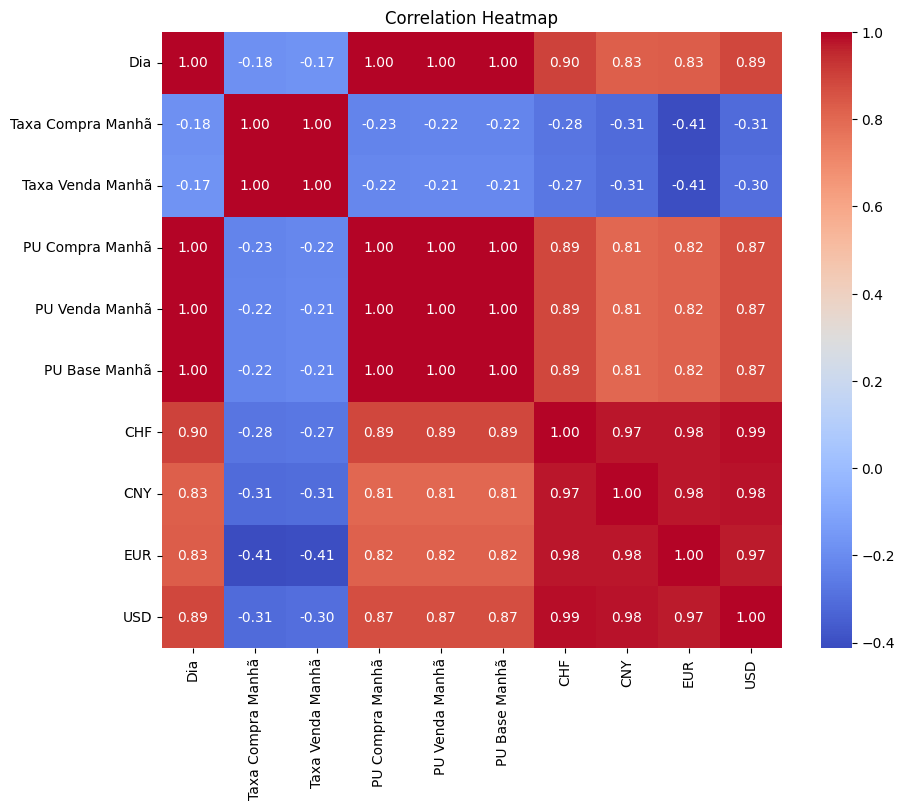

In [472]:
plt.figure(figsize=(10, 8))  # Set the size of the plot
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt=".2f")  # Create the heatmap
plt.title('Correlation Heatmap')  # Add a title to the plot
plt.show()

### Outro dado ou moeda do seu interesse...

Agora, vamos adicionar valores de ações brasileiras da Petrobrás, Embraer e Soja (?)

### SELIC

Dica: use as funções da biblioteca bcb para importar a taxa de juros no Brasil durante o período em análise!

In [474]:
from bcb import TaxaJuros

In [475]:
em = TaxaJuros()

In [476]:
from bcb import sgs

# Busca a série da SELIC no SGS
selic = sgs.get({'selic':432}, start = START_DATE)

# Plota
fig = px.line(selic, y='selic', title='Taxa de Juros no Brasil (SELIC)')
fig

In [477]:
# lembre de formatar o dataframe de SELIC, DOLAR ETC PARA UM COLUNA COM INDICE DATETIME! ;)

### Expectativa IPCA

In [478]:
from bcb import Expectativas

In [479]:
em = Expectativas()
em.describe()

EntitySets:
  ExpectativasMercadoTop5Anuais
  ExpectativaMercadoMensais
  ExpectativasMercadoInflacao24Meses
  ExpectativasMercadoInflacao12Meses
  ExpectativasMercadoSelic
  ExpectativasMercadoTop5Selic
  ExpectativasMercadoTop5Mensais
  ExpectativasMercadoTrimestrais
  ExpectativasMercadoAnuais


In [480]:
ep = em.get_endpoint('ExpectativasMercadoAnuais')

In [481]:
# crie uma rotina para importar os dados da expectativa do IPCA para as datas de interesse...

In [482]:
ipca_data.head(3)

NameError: name 'ipca_data' is not defined

### Índice macroeconômico

Caso você importe outro índice, indicar aqui.

### Combine todas suas informações em um DataFrame

Após juntar (coletar) todas suas informações macroeconômicas, junte tudo em um único dataframe. NO exemplo abaixo, eu mostro um head de uma solução proposta.


**Atenção**: Se usar mais algum índice, justifique quais indicadores macroeconômicos vocês estão usando!

In [ ]:
merged_df.head(5)

In [ ]:
len(merged_df)

In [ ]:
fig = px.line(merged_df, y=['USD', 'selic', 'Taxa Compra Manhã'], title='Taxa de Juros no Brasil (SELIC)')
fig

In [ ]:
fig = px.line(merged_df, y=['IPCA', 'selic'], title='Taxa de Juros no Brasil (SELIC)')
fig

## Parte II -  Pré-Processamento

Proponha uma pipeline de pré-processamento dos dados para regressão, se você achar necessário.


**Pontuação: 10 pontos**

## Parte III - Experimentos

O objetivo desta prática é avaliar as seguintes técnicas de regressão:

- Regressão Linear
- k-NN para regressão
- Regressão com Árvore de Decisão
- __Método de regressão que você acha interessante avaliar__


**Pontuação 50 pontos**

In [ ]:
df.head(5)

### Experimento (1) - Regressão Simples

Utilizando uma regressão linear simples, avalie o resultado para prever o atributo **Taxa Compra Manhã**. Observe a proposta abaixo para divisão do X e y para seu experimento.

In [ ]:
y = df['Taxa Compra Manhã']
X = df.drop('Taxa Compra Manhã', axis = 1)

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = ..)  # qual será uma boa taxa de divisão???

In [ ]:
from sklearn import tree

model = tree.DecisionTreeRegressor()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

Crie uma função para avaliar as métricas de regressão a partir do y_test e y_pred.

### Experimento (2) - Regressão com k-NN

In [ ]:
def get_regression_scores(y_test, y_pred):


Plotando os valores reais junto com as predições

In [ ]:
import matplotlib.pyplot as plt
import datetime

plt.figure(figsize=(20, 7))
plt.plot(df.index, y, 'b-', label = 'actual')
plt.plot(y_test.index, y_pred, 'ro', label = 'prediction')
plt.plot(y_train.index, y_train, 'yo', label = 'training')
plt.legend()

### Experimento (3) - Regressão com Árvore de Decisão

### Experimento (4) - Regressão considerando os dados como uma série temporal.


Considerando a melhor técnica de regressão, avalie agora os dados considerando uma série temporal!

Será que o melhor resultado para esta predição é com um random test split? Avalie agora como uma série temporal.

Inicialmente usamos train_test_split para fazer o holdout

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = ..., shuffle=False) # parâmetro faltante de proposito

Vamos plotar os valores de treino e teste para visualizar que estaremos treinando com dados do passado e testando com dados não vistos (do 'futuro').

In [ ]:
import matplotlib.pyplot as plt
import datetime

plt.figure(figsize=(20, 7))
plt.plot(df.index, y, 'b-', label = 'actual')
plt.plot(y_test.index, y_test, 'ro', label = 'prediction')
plt.plot(y_train.index, y_train, 'yo', label = 'training')
plt.legend()

In [ ]:
# veja um possível resultado que eu tive rodando...
import matplotlib.pyplot as plt
import datetime

plt.figure(figsize=(20, 7))
plt.plot(df.index, y, 'b-', label = 'actual')
plt.plot(y_test.index, y_pred, 'ro', label = 'prediction')
plt.plot(y_train.index, y_train, 'yo', label = 'training')
plt.legend()

Fazendo o holdout...

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, shuffle=False)

### Experimento (5) - Considerando os dados como uma série temporal e usando validação cruzada.

Novamente, escolha um modelo e realize:



1.   Validação cruzada considerando série temporal para o melhor modelo.
2.   Avalie o conjunto de treino com os melhores parâmetros indicados.


In [ ]:
from sklearn.model_selection import TimeSeriesSplit

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, shuffle=False)
tss = TimeSeriesSplit()

Vamos visualizar como o TimesSeriesSplit divide os dados a cada iteração, observando que se mantem a característica de treinar com dados passados e testar com dados futuros.

In [ ]:
import matplotlib.pyplot as plt
import datetime

for train_index, test_index in tss.split(X_train):
    plt.figure(figsize=(20, 7))
    plt.plot(df2.index, y, 'b-', label = 'actual')
    plt.plot(test_index, y[test_index], 'ro', label = 'prediction')
    plt.plot(train_index, y[train_index], 'yo', label = 'training')
    plt.legend()
    plt.plot()

Observe que, para a validação cruzada, passamos o TSS (TimeSeriesSplit) para o validador (cross_validate) através do parâmetro cv=tss.

Após a validação cruzada, quando já temos os resultados médios, retreinamos o modelo com todos os dados de treinamento e testamos nos dados de treino e teste.

In [ ]:
import matplotlib.pyplot as plt
import datetime

y_test_pred = model.fit(X_train, y_train).predict(X_test)

In [ ]:
import matplotlib.pyplot as plt
import datetime

plt.figure(figsize=(20, 7))
plt.plot(df.index, y, 'b-', label = 'actual')
plt.plot(y_test.index, y_pred, 'ro', label = 'prediction')
plt.plot(y_train.index, y_train, 'yo', label = 'training')
plt.legend()

### Como o modelo poderia ser melhorado?

**Pontuação EXTRA: 20 pontos**


Indique nesta célula de texto como você poderia surgerir um melhor modelo de predição.

Obs: caso a análise seja condizente e melhore mesmo, e a dupla alcance 100 pontos, a pontuação poderá ir para outra prática.

In [ ]:
# inserir códigos para melhorar o modelo

# são 20 pontos extra!

## Referências p/ Dados Financeiros

- [Biblioteca Python BCB](https://github.com/wilsonfreitas/python-bcb)

- [Python BCB](https://wilsonfreitas.github.io/python-bcb/sgs.html)

- [Nasdaq Data Link](https://github.com/Nasdaq/data-link-python/tree/main)

- [Yahoo Finance](https://www.geeksforgeeks.org/get-financial-data-from-yahoo-finance-with-python/)

Visualização

- [Great Tables](https://posit-dev.github.io/great-tables/articles/intro.html)